In [1]:
from pathlib import Path

INPUT_PATH = Path('../inputs')
OUTPUT_PATH = Path('../outputs')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from collections import OrderedDict
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(999)

class Net(nn.Module):
    def __init__(self, input_size, out_size):
        super(Net, self).__init__()
        layer1 = self.get_linear_with_relu(input_size, 500)
        layer2 = nn.Linear(500, out_size)
        self.layers = nn.ModuleList([layer1, layer2])
        self.forward_vals = []
        
    def forward(self, x):
        self.forward_vals.clear()
        for layer in self.layers:
            x = layer(x)
            self.forward_vals.append(x)
        return x
    
    def get_linear_with_relu(self, inp, out):
        return nn.Sequential(nn.Linear(inp, out), nn.ReLU())
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
train_kwargs = {'batch_size': batch_size,
               'shuffle': True}
test_kwargs = {'batch_size': batch_size,
              'shuffle': True}

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

dataset1 = datasets.MNIST(INPUT_PATH/'mnist', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST(INPUT_PATH/'mnist', train=False,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

model = Net(28*28, 10).to(device)
optimizer = optim.Adadelta(model.parameters(), lr=1e-2)
            
model

Net(
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=500, bias=True)
      (1): ReLU()
    )
    (1): Linear(in_features=500, out_features=10, bias=True)
  )
)

In [3]:
len(train_loader)*batch_size

60032

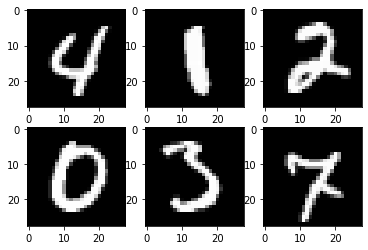

In [4]:
from matplotlib import pyplot as plt

examples = iter(test_loader)
example_data, example_targets = examples.next()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

### Target Model Training

In [5]:
# import copy
# import warnings
# warnings.filterwarnings("ignore") 

# def train(model, device, train_loader, optimizer, epoch):
#     model.train()
#     for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
#         # print(data.size(), data.view(data.size(0), -1).size())
#         optimizer.zero_grad()
#         output = model(data.view(data.size(0), -1))
#         loss = F.cross_entropy(output, target)
#         loss.backward()
#         optimizer.step()
#         if batch_idx % 100 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))
            

# def test():
#     with torch.no_grad():
#         n_correct = 0
#         n_samples = 0
#         for images, labels in test_loader:
#             images = images.reshape(-1, 28*28).to(device)
#             labels = labels.to(device)
#             outputs = model(images)
#             # max returns (value ,index)
#             _, predicted = torch.max(outputs.data, 1)
#             n_samples += labels.size(0)
#             n_correct += (predicted == labels).sum().item()

#     acc = 100.0 * n_correct / n_samples
#     print(f'Accuracy of the network on the 10000 test images: {acc} %')
#     return acc


# best_acc = -1
# best_model = None
# for epoch in range(1, 120):
#     train(model, device, train_loader, optimizer, epoch)
#     acc = test()
#     if acc > best_acc:
#         best_acc = acc
#         best_model = copy.deepcopy(model)
#         print(f'new best acc={best_acc}')
#     else:
#         print(f'current acc={acc}, prev_best_acc={best_acc}')

# state = {
#     'model_state': best_model.state_dict(),
#     'test_acc': best_acc
# }
# torch.save(state, OUTPUT_PATH/'state_small_nn.pt')
# print('best model saved')

### Reverse Model Training

In [6]:
state = torch.load(OUTPUT_PATH/'state_small_nn.pt')
state.keys()

dict_keys(['model_state', 'test_acc'])

In [7]:
model.load_state_dict(state['model_state'])
model.to(device)

for param in model.parameters():
    param.requires_grad = False
                                 
model

Net(
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=500, bias=True)
      (1): ReLU()
    )
    (1): Linear(in_features=500, out_features=10, bias=True)
  )
)

In [8]:
config_dict = {
    'epochs': 600,
    'alpha': 1,
    'lr': 1e-3,
    'lr_sched': 'exp',
    'gamma': 0.99,
    'loss': 'abs',
    'min_lr': 3e-5
}

In [9]:
class InvNet(nn.Module):
    def __init__(self, input_size, out_size):
        super(InvNet, self).__init__()
        layer1 = self.get_linear_with_relu(input_size, 500)
        layer2 = nn.Linear(500, out_size)
        self.layers = nn.ModuleList([layer1, layer2])
        self.forward_vals = []
        
    def forward(self, x):
        self.forward_vals.clear()
        for layer in self.layers:
            x = layer(x)
            self.forward_vals.append(x)
        return x
    
    def get_linear_with_relu(self, inp, out):
        return nn.Sequential(nn.Linear(inp, out), nn.ReLU())
    
inv_model = InvNet(10, 28*28)
inv_model.to(device)
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

test_kwargs = {'batch_size': batch_size,
              'shuffle': True}
train_qmnist = datasets.QMNIST(INPUT_PATH/'qmnist', train = True, download= True,
                             transform=transform) 
test_qmnist = datasets.QMNIST(INPUT_PATH/'qmnist', train = False, download= True,
                             transform=transform)

print(f'size of inv data={train_qmnist}')
inv_data_loader = torch.utils.data.DataLoader(train_qmnist, **test_kwargs)

if config_dict['loss'] == 'abs':
    loss_fn = nn.L1Loss()
else:
    loss_fn = nn.MSELoss()

optimizer = optim.Adam(inv_model.parameters(), lr=config_dict['lr'])

lr_sched = None
if config_dict['lr_sched'] == 'exp':
    lr_sched = optim.lr_scheduler.ExponentialLR(optimizer, config_dict['gamma'], verbose=False)

inv_model

size of inv data=Dataset QMNIST
    Number of datapoints: 60000
    Root location: ../inputs/qmnist
    Split: train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


InvNet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=500, bias=True)
      (1): ReLU()
    )
    (1): Linear(in_features=500, out_features=784, bias=True)
  )
)

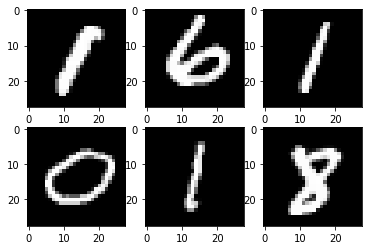

In [10]:
from matplotlib import pyplot as plt
import random

for i in range(6):
    example_data, example_target = test_qmnist[random.randint(0, len(train_qmnist))] # TODO for test only change dataloader !!!!!
    plt.subplot(2,3,i+1)
    plt.imshow(example_data.squeeze(), cmap='gray')
plt.show()

In [11]:
import copy

tgt_to_inv_layer_map = {0: 1, 1: 0}

def train_inv(model, inv_model, device, data_loader, optimizer, epoch, alpha, layer_wise_only=False, layer_num=-1):
    model.train()
    
    total_loss = 0
    total_loss_layer = 0
    total_loss_img = 0
    total_loss_cyc = 0
    
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device).view(data.size(0), -1), target.to(device)  # torch.Size([128, 784]) torch.Size([128])
        optimizer.zero_grad()
    
        out = model(data)  
        inv_out = inv_model(out)
        
        # step 1- layer wise load
        loss_layer = layer_wise_loss(model, inv_model, data)
        
        if not layer_wise_only:
            # step 2- upto layer-k loss
            loss_img = k_layer_loss(model, inv_model, data)

            # step 3- full network output loss
            loss_cyc = cycle_consistency_inversion_loss(model, data, inv_out)
        else:
            loss_img = torch.tensor(0)
            loss_cyc = torch.tensor(0)
        
        loss = loss_layer + loss_img + (alpha*loss_cyc)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_loss_layer += loss_layer.item()
        total_loss_img += loss_img.item()
        total_loss_cyc += loss_cyc.item()
        
    return total_loss / (batch_idx+1), total_loss_layer / (batch_idx+1), \
            total_loss_img / (batch_idx+1), total_loss_cyc / (batch_idx+1)


def train_inv_progressive(model, inv_model, device, data_loader, optimizer, epoch, alpha, layer_wise_only=False):
    model.train()
    
    total_loss = 0
    total_loss_layer = 0
    total_loss_img = 0
    total_loss_cyc = 0
    
    for layer_num in range(len(model.layers)):
        for batch_idx, (data, target) in enumerate(data_loader):
            data, target = data.to(device).view(data.size(0), -1), target.to(device)  # torch.Size([128, 784]) torch.Size([128])
            optimizer.zero_grad()

            out = model(data)  
            inv_out = inv_model(out)

            loss = layer_wise_loss_progressive(model, inv_model, data, layer_num)
            
            loss.backward()
            optimizer.step()    
        
        if layer_num > 0: # TODO for test only change dataloader !!!!!
            for batch_idx, (data, target) in enumerate(data_loader):
                data, target = data.to(device).view(data.size(0), -1), target.to(device)  # torch.Size([128, 784]) torch.Size([128])
                optimizer.zero_grad()

                out = model(data)  
                inv_out = inv_model(out)

                loss_layer = layer_wise_loss_progressive(model, inv_model, data, layer_num)
                loss_img = k_layer_loss_progressive(model, inv_model, data, layer_num)
                loss_cyc = cycle_consistency_inversion_loss(model, data, inv_out, layer_num)

                loss = loss_layer + loss_img + (alpha*loss_cyc)

                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                total_loss_layer += loss_layer.item()
                total_loss_img += loss_img.item()
                total_loss_cyc += loss_cyc.item()
    
    div = (batch_idx+1)*len(inv_model.layers)
    return total_loss / div, total_loss_layer / div, \
            total_loss_img / div, total_loss_cyc / div


def layer_wise_loss(model, inv_model, inp, k=-1):
    loss = 0
    for layer_num, layer in enumerate(model.layers[:k+1] if k > -1 else model.layers):
        tgt_layer_in = inp if layer_num == 0 else model.forward_vals[layer_num-1]  # get the input tensor for this layer in tgt model
        tgt_layer_out = model.forward_vals[layer_num]  # get the output of i-th target model layer 
        inv_layer = inv_model.layers[tgt_to_inv_layer_map[layer_num]]  # get the corresponding layer in reverse model
        inv_layer_out = inv_layer(tgt_layer_out)  # feed the target model layer output to reverse model layer
        loss += loss_fn(inv_layer_out, tgt_layer_in)  # outputs of both layer should be similar
        
    return loss


def layer_wise_loss_progressive(model, inv_model, inp, layer_num):
    tgt_layer_in = inp if layer_num == 0 else model.forward_vals[layer_num-1]  # get the input tensor for this layer in tgt model
    tgt_layer_out = model.forward_vals[layer_num]  # get the output of i-th target model layer 
    inv_layer = inv_model.layers[tgt_to_inv_layer_map[layer_num]]  # get the corresponding layer in reverse model
    inv_layer_out = inv_layer(tgt_layer_out)  # feed the target model layer output to reverse model layer
    return loss_fn(inv_layer_out, tgt_layer_in)  # outputs of both layer should be similar


def k_layer_loss(model, inv_model, inp, k=-1):
    loss = 0
    for layer_num, layer in enumerate(model.layers[:k+1] if k > -1 else model.layers):
        tgt_layer_out = model.forward_vals[layer_num]
        x = tgt_layer_out
        for layer in inv_model.layers[-(1+layer_num):]:
            x = layer(x)
        loss += loss_fn(x, inp)
    
    return loss


def k_layer_loss_progressive(model, inv_model, inp, layer_num):
    tgt_layer_out = model.forward_vals[layer_num]
    x = tgt_layer_out
    for layer in inv_model.layers[-(1+layer_num):]:
        x = layer(x)
    return loss_fn(x, inp)


def cycle_consistency_inversion_loss(model, inp, inv_out, k=-1):
    org_activations = copy.deepcopy(model.forward_vals[:k+1] if k > -1 else model.forward_vals)
    out_for_inv_input = model(inv_out)  # pass the input image generated by inverted network
    inv_activations = model.forward_vals[:k+1] if k > -1 else model.forward_vals
    loss = 0
    for org_actv, actv in zip(org_activations, inv_activations):
        loss += loss_fn(actv, org_actv)
        
    return loss

In [12]:
import time
import sys
import wandb
import os
import numpy as np


def round_(n, d=5):
    return np.round(n, d)

run_id = 'fresh-nonProgressive-expLrSched-2'
change_desc = 'fresh training with non-progressive, exponential LR scheduler'
is_resume = True
run_path = OUTPUT_PATH/'runs'/run_id
run_path.mkdir(parents=True, exist_ok=True)

EPOCHS = config_dict['epochs']
ALPHA = config_dict['alpha']
start_epoch = 0
prev_best_loss = 999999
total_training_time = 0

state_path = run_path/'final_state_small_inv_nn.pt'

if is_resume and state_path.exists():
    state = torch.load(state_path)
    inv_model.load_state_dict(state['model_state'])
    optimizer.load_state_dict(state['optimizer'])
    if lr_sched:
        lr_sched.load_state_dict(state['lr_sched'])
    start_epoch = state['epoch']+1
    prev_best_loss = state['prev_best_loss']

    print(f'resuming training for {run_id} from epoch {start_epoch}, last loss {state["loss"]} prev_best_loss {prev_best_loss}')
    

wandb.init(project='nn-are-reversible',
           entity='nayash', save_code=True, id=run_id,
           name=run_id, notes=change_desc,
           dir=run_path,
           resume='allow',
           config=config_dict)
wandb.watch(inv_model)

if run_id in ['test', 'temp']:
    os.environ['WANDB_MODE'] = 'offline'
    print(f'run_id={run_id}, so wandb is disabled!')
          
for epoch in range(start_epoch, EPOCHS):
    stime = time.time()
    total_loss, total_loss_layer, total_loss_img, total_loss_cyc = \
        train_inv(model, inv_model, device, inv_data_loader, optimizer, epoch, ALPHA)

    epoch_time = time.time() - stime
    total_training_time += epoch_time
    
    print(f'epoch={epoch}/{EPOCHS} loss={round_(total_loss)}, loss_layer={round_(total_loss_layer)}, loss_img={round_(total_loss_img)}, loss_cyc={round_(total_loss_cyc)}, epoch_duration={round(epoch_time)} secs')
    
    wandb.log({
        'loss':total_loss,
        'loss_layer':total_loss_layer,
        'loss_img':total_loss_img,
        'loss_cyc':total_loss_cyc,
        'lr': optimizer.param_groups[0]['lr']
    })
    
    if lr_sched is not None and optimizer.param_groups[0]['lr'] > config_dict['min_lr']:
        lr_sched.step()
    
    if total_loss < prev_best_loss:
        prev_best_loss = total_loss
        state = {
            'model_state': inv_model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lr_sched': lr_sched.state_dict() if lr_sched else None,
            'epoch': epoch,
            'loss': prev_best_loss,
            'prev_best_loss': prev_best_loss
        }
        torch.save(state, run_path/'state_small_inv_nn.pt')
        print(f'new best loss={total_loss}')

        
state = {
    'model_state': inv_model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'lr_sched': lr_sched.state_dict() if lr_sched else None,
    'epoch': epoch,
    'loss': total_loss,
    'prev_best_loss': prev_best_loss
    }
torch.save(state, state_path)
        
print(f'{EPOCHS} epochs finished in {total_training_time/60} mins')
wandb.finish()

wandb: Currently logged in as: nayash (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


epoch=0/600 loss=3.81406, loss_layer=1.72157, loss_img=1.05442, loss_cyc=1.03807, epoch_duration=9 secs
new best loss=3.8140607764726
epoch=1/600 loss=2.56854, loss_layer=1.20621, loss_img=0.71976, loss_cyc=0.64257, epoch_duration=8 secs
new best loss=2.5685359420044334
epoch=2/600 loss=2.37586, loss_layer=1.10739, loss_img=0.66294, loss_cyc=0.60553, epoch_duration=8 secs
new best loss=2.375859912270422
epoch=3/600 loss=2.28834, loss_layer=1.05608, loss_img=0.63054, loss_cyc=0.60173, epoch_duration=8 secs
new best loss=2.2883429405277473
epoch=4/600 loss=2.21517, loss_layer=1.02334, loss_img=0.60791, loss_cyc=0.58392, epoch_duration=8 secs
new best loss=2.215169639729742
epoch=5/600 loss=2.16864, loss_layer=1.00004, loss_img=0.59099, loss_cyc=0.57761, epoch_duration=8 secs
new best loss=2.1686358629767573
epoch=6/600 loss=2.12891, loss_layer=0.98218, loss_img=0.57786, loss_cyc=0.56888, epoch_duration=8 secs
new best loss=2.128910168401722
epoch=7/600 loss=2.09591, loss_layer=0.96761, l

KeyboardInterrupt: 

In [13]:
state = {
    'model_state': inv_model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'lr_sched': lr_sched.state_dict() if lr_sched else None,
    'epoch': epoch,
    'loss': total_loss,
    'prev_best_loss': prev_best_loss
    }
torch.save(state, state_path)
wandb.finish()

loss,1.6789
loss_layer,0.77164
loss_img,0.46401
loss_cyc,0.44325
lr,3e-05
_runtime,4664
_timestamp,1635961784
_step,545


loss,█▆▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_layer,█▆▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_img,█▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_cyc,█▇▆▅▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,█▇▆▆▅▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


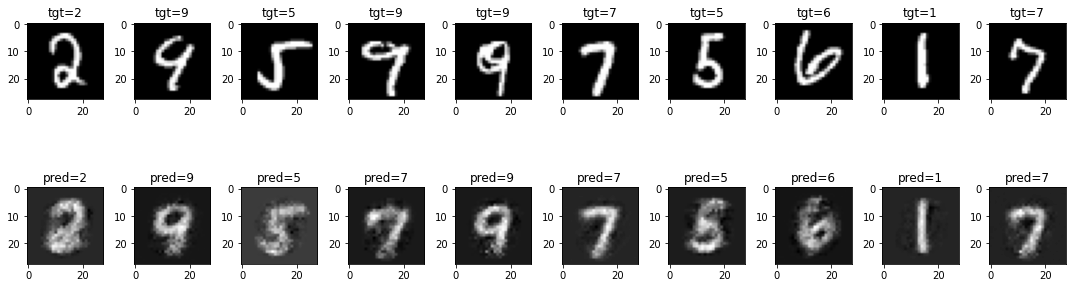

In [39]:
state = torch.load(run_path/'state_small_inv_nn.pt')
inv_model.load_state_dict(state['model_state'])

plt.figure(figsize=(15, 5))
total_plts = 10
for i in range(total_plts):
    _ = np.random.randint(len(test_qmnist))
    inp = model(test_qmnist[_][0].view(1, -1).to(device))
    label = torch.argmax(inp)
    o = inv_model(inp)
    img = o.reshape((28, 28)).cpu().detach().numpy()
    ax_org = plt.subplot(2, 10, i+1)
    plt.imshow(test_qmnist[_][0].squeeze().numpy(), cmap='gray')
    ax_pred = plt.subplot(2, 10, i+1+total_plts) 
    plt.imshow(img, cmap='gray')
    ax_pred.set_title(f'pred={label}')
    ax_org.set_title(f'tgt={test_qmnist[_][1]}')
plt.tight_layout()
plt.show()

Now, let's see how identifiable the images generated using reversed model are...

In [50]:
from tqdm.notebook import tqdm

tgts = []
preds = []
with torch.no_grad():
    for i, test_sample in enumerate(tqdm(test_qmnist)):
        inp = model(test_qmnist[i][0].view(1, -1).to(device))
        tgt = test_qmnist[i][1]
        o = inv_model(inp)  # generate image using inverted model
        pred = torch.argmax(torch.softmax(model(o), -1))
        tgts.append(tgt)
        preds.append(pred.item())

print(f'accuracy on generated images = {(np.array(tgts) == np.array(preds)).sum()/len(tgts) * 100}')

  0%|          | 0/60000 [00:00<?, ?it/s]

accuracy on generated images = 97.68666666666667
